In [1]:
# all useful libraries

import matplotlib.pyplot as plt
import numpy as np
from sklearn.manifold import TSNE

In [2]:
# function which takes two pmfs and returns cross entropy
def calculateEntropy(pmf):
    np_pmf = np.array(pmf)
    log_multiplier = lambda x : -x*np.log2(x)
    # checking for ambiguity case when x = 0
    entropy = [log_multiplier(x) if x != 0 else 0 for x in np_pmf]
    total_entropy = np.sum(entropy)
    return total_entropy
    
def calculateCrossEntropy(p,q):
    np_p = np.array(p)
    np_q = np.array(q)
    log_multiplier = lambda x,y : -x*np.log2(y)
    indi_entropy = [log_multiplier(x,y) if y != 0 else 0 for x,y in zip(np_p,np_q)]
    total_entropy = np.sum(indi_entropy)
    return total_entropy

# function which calculates KL divergence
def calculateKlDivergence(p,q):
    entropy = calculateEntropy(p)
    cross_entropy = calculateCrossEntropy(p,q)
    kl_divergence = cross_entropy-entropy
    return kl_divergence

In [3]:
def getNormalizedValues(image):
    # gray scales in the range from 0 to 255 inclusive
    gray_scales = [0]*256

    # iterate over the matrix and update the frequency
    for i in image:
        for j in i:
            gray_scales[j] += 1

    # find total number of pixels to normalize
    pixels = np.sum(gray_scales)
    # normalize the frequency of pixels
    normalized_gray_scales = [pixel/pixels for pixel in gray_scales]
    # return the normalized values which acts as pmf
    return normalized_gray_scales

def scaleto255(image):
    image = np.array(image)*255
    image = image.astype(int)
    return image

# utility bernoulli function which returns p
def bern(p):
    return [p,1-p]

In [4]:
image_left = plt.imread('/content/drive/MyDrive/deeplearning/assignment2/left.png')
image_right = plt.imread('/content/drive/MyDrive/deeplearning/assignment2/right.png')

pmf_left = getNormalizedValues(scaleto255(image_left))
pmf_right = getNormalizedValues(scaleto255(image_right))

ce = calculateCrossEntropy(pmf_left,pmf_right)
print("Cross entropy of stereo image pair : ",ce)

Cross entropy of stereo image pair :  7.273398119987325


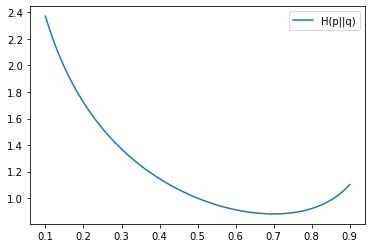

In [5]:
p = bern(0.7)
q = np.linspace(0.1,0.9,315)
# H(p||q)
cross_entropy_pq = []
for i in range(len(q)):
    cross_entropy_pq.append(calculateCrossEntropy(p,bern(q[i])))
plt.plot(q,cross_entropy_pq,label = 'H(p||q)')
plt.legend()

Clearly from the plot one can observe that the minimum of the graph is obtained where q = p. So minimizing ```H(p||q)``` gives us matched pdfs.

In [6]:
def calculateJsDivergence(p,q):
    m = [(i+j)/2 for i,j in zip(p,q)]
    kl_pm = calculateKlDivergence(p,m)
    kl_qm = calculateKlDivergence(q,m)
    return kl_pm+kl_qm

In [7]:
pmf_left = getNormalizedValues(scaleto255(image_left))
pmf_right = getNormalizedValues(scaleto255(image_right))

js = calculateJsDivergence(pmf_left,pmf_right)
print("JS Divergence of stereo image pair : ",js)

JS Divergence of stereo image pair :  0.007346079538626427


In [8]:
# symmetric

print("Is JS divergence symmetric : ",calculateJsDivergence(pmf_left,pmf_right) == calculateJsDivergence(pmf_right,pmf_left))
print("Is KL divergence symmetric : ",calculateKlDivergence(pmf_left,pmf_right) == calculateKlDivergence(pmf_right,pmf_left))

Is JS divergence symmetric :  True
Is KL divergence symmetric :  False


In [9]:
def check_marginals(pdf,rx,sy):
    pdf = np.array(pdf)
    row_sum = pdf.sum(axis=1)
    col_sum = pdf.sum(axis=0)
    rx = np.array(rx)
    sy = np.array(sy)
    if ((row_sum == rx).all() == True and (col_sum == sy).all() == True) or ((row_sum == sy).all() == True and (col_sum == rx).all() == True):
        return True
    return False

In [10]:
pdf = [[0.25,0.25],[0.25,0.25]]
rx = [0.5,0.5]
sy = [0.5,0.5]
print(check_marginals(pdf,rx,sy))

True


# 2. t-SNE

### 2.a 1) Crowding problem
Sometimes, it is impossible to preserve the distance in all neighborhood(N). Such a problem is called Crowding problem. What actually happens is TSNE tries to preserve the distance in the neighbourhood. Consider a square or rectangular object in 2d space and when tsne is applied, it is obvious that we couldn't preserve the distance between every vertex in the neighbourhood. This is portrayed as crowding problem.

### 2.a 2) How does the choice of the Student t-distribution in the low dimensional embedding space help address the crowding problem?
The t-SNE algorithm reduces dimensionality of data where the focus lies on keeping the data of very similar data points close together in reduced dimension space. It uses the local structure of the data using student t-distribution choice to compute the similarity between the two points in lower dimesion space. We use this instead of guassian distribution.

### 2.a 3) What other important changes have been made in t-SNE relative to SNE?
t-SNE uses a symmetric version of SNE cost function with simpler gradients and the student t distribution computes the similarity between two points in low dimensional space effectively.

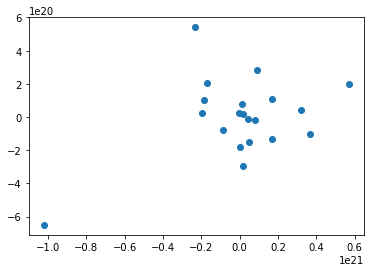

In [11]:
# 2.b
mean,mean1,sd = np.ones(10),np.ones(10)*10,np.identity(10)*0.01
X1,X2 = np.random.multivariate_normal(mean,sd,10),np.random.multivariate_normal(mean1, sd, 10)
x = np.concatenate([X1, X2])

def distance(x):
    r,c = x.shape
    matrix = np.zeros((r,r))
    for i in range(r):
        for j in range(c):
            matrix[i][j] = np.linalg.norm(x[i]-x[j])**2
    return -matrix
def dm_pji(x,i,j,sigma):
    distance_x = distance(x)
    exponential_distance_x = np.exp(distance_x)
    exponential_distance_x /= 2
    exponential_distance_x /= (sigma**2)
    return exponential_distance_x[i][j]/(np.sum(exponential_distance_x[i]))
def dm_qji(i,j,y):
    distance_y = distance(y)
    numerator = 1/(1+(-1*distance_y[i][j]))
    denominator = np.sum(1/(1+(-1*distance_y[i])))
    if denominator == 0: return denominator
    return numerator/denominator
def ptable(sigma,x):
    r,c = x.shape
    matrix = np.zeros([r,r])
    for i in range(r):
        for j in range(r):
            matrix[i][j] += dm_pji(x,i,j,sigma) 
            matrix[i][j] += dm_pji(x,j,i,sigma)
            matrix[i][j] /= 2*r
    return matrix
def qtable(y):
    r,c = y.shape
    matrix = np.zeros((r,r))
    for i in range(r):
        for j in range(r):
            matrix[i][j] = (dm_qji(i,j,y)+dm_qji(j,i,y))/2*r
    return matrix
def gradient_descent(i,p,q,y):
    r,c = y.shape
    mat = np.zeros((r,c))
    for i in range(r):
        sum = np.zeros(2)
        for j in range(r):
            denominator = ((y[i]-y[j])*(p[i][j]-q[i][j])*(1+np.linalg.norm(y[i]-y[j])**2))
            if (denominator == 0).all() == True: continue
            sum += 1/denominator
        mat[i] = sum
    return mat
def tsne(x,a,learning_rate,sigma,iters):
    y_prev = np.zeros((20,2))
    sd = np.identity(2)/1e-4
    y_prev_d = y_prev.copy()
    y = np.random.multivariate_normal(np.zeros(2),sd,20)
    for i in range(iters):
        des = gradient_descent(i,ptable(sigma,x),qtable(y),y)
        y = y_prev + learning_rate*des + a*(y_prev-y_prev_d)
        y_prev_d = y_prev
        y_prev = y
    return y

y = tsne(x,2,0.55,2,50)
plt.scatter(y[:,0],y[:,1])

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,


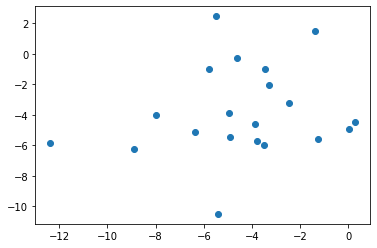

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,


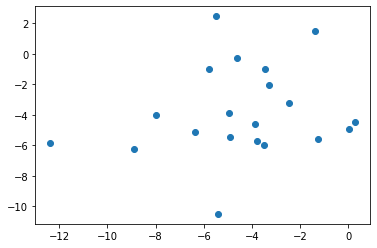

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,


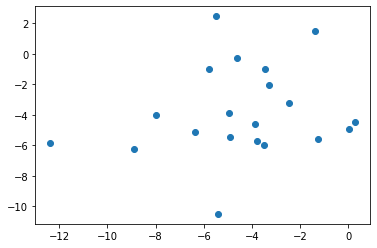

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,


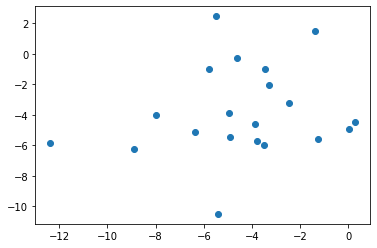

In [12]:
# 2.c

for perplexity_ in [20,30,40,50]: 
    x2dim =TSNE(n_components=2,perplexity=perplexity_, n_iter=250,learning_rate='auto', random_state=0).fit_transform(x)
    plt.scatter(x2dim[:, 0], x2dim[:, 1])
    plt.show()

# 3. Convolution & Correlation

In [13]:
# utility functions for populating the image
def mirror(seq):
    output = list(seq[::-1])
    output.extend(seq[1:])
    return output
def populatematrix(matrix,w,k):
    matrix = mirror([mirror(sublist) for sublist in matrix])
    while len(matrix) <= w+k-1:
        matrix = mirror(matrix)
    if len(matrix) >= w+k-1:
        matrix = matrix[:w+k-1]
    matrix = np.transpose(matrix)
    if len(matrix) >= w+k-1:
        matrix = matrix[:w+k-1]
    matrix = np.transpose(matrix)
    return matrix

# function which convolutes and gives the value
def convolute(m1,m2,r,c,h):
    sum = 0
    for i in range(r):
        for j in range(c):
            for k in range(h):
                sum += m1[i][j][k]*m2[i][j][k]
    return sum

# function which correlates and gives the value
def correlate(m1,m2,r,c,h):
    sum = 0
    for i in range(r):
        for j in range(c):
            for k in range(h):
                sum += m1[i][j][k]*m2[r-i-1][c-j-1][h-1-k]
    return sum

# function which gives the kernel
def getKernel(image,k,c):
    kernel = np.zeros((k,k,c))
    for x in range(k):
        for y in range(k):
            for z in range(c):
                kernel[x][y][z] = image[x][y][z]
    return kernel

# convolution function
def convolution(image,k):
    pop_image = populatematrix(image,len(image),k)
    kernel = getKernel(image,k,3)
    cm = []
    for i in range(len(image)):
        for j in range(len(image[0])):
            temp_matrix = pop_image[i:i+k,j:j+k,:3]
            cm.append(convolute(temp_matrix,kernel,k,k,3))
    cm = np.array(cm)
    cm = cm.reshape(256,256)
    cm = np.transpose(cm)
    return np.fliplr(np.rot90(cm))

# correlation function
def correlation(image,k):
    pop_image = populatematrix(image,len(image),k)
    kernel = getKernel(image,k,3)
    cm = []
    for i in range(len(image)):
        for j in range(len(image[0])):
            temp_matrix = pop_image[i:i+k,j:j+k,:3]
            cm.append(correlate(temp_matrix,kernel,k,k,3))
    cm = np.array(cm)
    cm = cm.reshape(256,256)
    cm = np.transpose(cm)
    return np.fliplr(np.rot90(cm))   

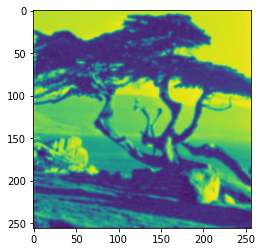

In [14]:
tree_path = '/content/drive/MyDrive/deeplearning/assignment2/4.1.06-tree.tiff'
tree = plt.imread(tree_path)

# set the k size
k = 3

# convolute the image
convolutedimage = convolution(tree,k)
plt.imshow(convolutedimage)

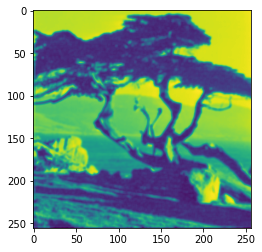

In [15]:
# correlate the image
correlatedimage = correlation(tree,k)
plt.imshow(correlatedimage)

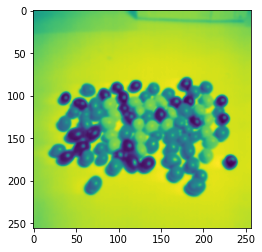

In [16]:
jelly_beans_path = '/content/drive/MyDrive/deeplearning/assignment2/4.1.08-jellybeans.tiff'
jelly_beans = plt.imread(jelly_beans_path)

convolutedimage = convolution(jelly_beans,k)
plt.imshow(convolutedimage)

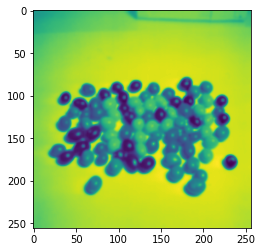

In [17]:
correlatedimage = correlation(jelly_beans,k)
plt.imshow(correlatedimage)